In [25]:
using Revise
using QuantumGraining
using QuantumCumulants
using QuantumOptics
using Symbolics
using OrdinaryDiffEq
using ModelingToolkit
using LaTeXStrings
using Plots

# Time-coarse grained Rabi model

To demonstrate the use of the method, we start with a simple but illustrative example -- the Rabi model. The Rabi model describes the interaction of a single field mode interacting with a two-level system. However, unlike the Jaynes-Cummings model, it does not assume the rotating-wave approximation (RWA). More concretely, the model is described by the following Hamiltonian terms in the interaction picture,

$$
    \begin{align*}
    &g_{\Omega}
    =
    \{\frac{g}{2}, \frac{g}{2}, \frac{g}{2}, \frac{g}{2}\} \\
    &h_{\Omega}
    =
    \{\hat{a}\hat{\sigma}_-, \hat{a}^\dagger \hat{\sigma}_+, \hat{a}\hat{\sigma}_+, \hat{a}^\dagger \hat{\sigma_-} \} \\
    &\Omega
    =
    \{
    - \big( \omega_c + \omega_a \big),
    \omega_c + \omega_a,
    - \omega_c + \omega_a,
    \omega_c - \omega_a
    \} \\
    &\hat{H} = \sum_{\omega \in \Omega} g_\omega h_\omega e^{-i\omega t}
\end{align*}
$$

We start by coding in the Hamiltonian. We use `QuantumCumulants` to handle the operator algebra, a `Symbolics` for handling the symbolic calculations.

In [26]:
@variables g ωc ωa
Ω = [-ωc - ωa, ωc + ωa, -ωc + ωa, ωc - ωa]
gvec = (g/2).*[1, 1, 1, 1]

# Hilbert space definitions (QuantumCumulants.jl)
h_cav = FockSpace(:cavity)
h_atom = NLevelSpace(:atom, (:g,:e))
h = tensor(h_cav, h_atom)

# Operator definitions
@qnumbers a::Destroy(h) σ::Transition(h)
σm = σ(:e, :g)
σp = σ(:g, :e)
hvec = [a*σm, a'*σp, a*σp, a'*σm]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 (a*σeg)
 (a′*σge)
 (a*σge)
 (a′*σeg)

## First-order time-coarse graining - the JC model

To first-order the corrections are only Hermitian, and depend on a single contraction coefficient.

$$
    C_{1,0}(\omega) = e^{- \frac{\omega^2 \tau^2}{2}}
$$

We can calculate the first-order by hand, and compare it to the results obtained by `QuantumGraining.jl`. For brevity, let us denote,
$$
    \overline{\omega} = \omega_c + \omega_a \rightarrow \hat{a}^\dagger \hat{\sigma}_+ \\
    \Delta = \omega_c - \omega_a \rightarrow \hat{a}^\dagger \sigma_-
$$

Collecting the relevant corrections,
$$
    \overline{\omega}: \ \ \ g_{a^\dagger \sigma_+} = \frac{g}{2} e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0 \\
    \Delta: \ \ \ g_{a^\dagger \sigma_-} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2} \\
    -\Delta: \ \ \ g_{a \sigma_+} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2}\\
    -\overline{\omega}: \ \ \ g_{a \sigma_-} = e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0
$$
which approximately gives the RWA Hamiltonian (it would be given directly for a cutoff filter).
$$
    H^{(1)} = \frac{g}{2} \left ( \hat{a}^\dagger \hat{\sigma}_- e^{i\Delta t} + \hat{a}\sigma_+ e^{-i\Delta t}\right )
$$



Equivalently, let us also do that by calling the `effective_hamiltonian_term` function, which calculates a single order of the TCG Hamiltonian.

In [27]:
g_eff_1, Ω_eff_1 = effective_hamiltonian(hvec, gvec, Ω, 1; as_dict=true)

(Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient}((a′*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2)), (a*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa - ωc)^2)), (a′*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa + ωc)^2))), Dict{QuantumCumulants.QMul{Nothing}, Num}((a′*σeg) => -ωa + ωc, (a*σge) => ωa - ωc, (a*σeg) => -ωa - ωc, (a′*σge) => ωa + ωc))

We can print the dictionaries to see the terms that are being calculated.

In [28]:
g_eff_1  

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 4 entries:
  (a′*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2))
  (a*σge)  => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  (a*σeg)  => (1//2)*g*exp(-0.5(τ^2)*((-ωa - ωc)^2))
  (a′*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa + ωc)^2))

As well as the frequencies,

In [29]:
Ω_eff_1

Dict{QuantumCumulants.QMul{Nothing}, Num} with 4 entries:
  (a′*σeg) => -ωa + ωc
  (a*σge)  => ωa - ωc
  (a*σeg)  => -ωa - ωc
  (a′*σge) => ωa + ωc

To visualize the result, it is useful to use the `symbolic_hamiltonian` function, which renders the Hamiltonian in Latex.

In [30]:
@variables t τ  # define symbolic variables for displaying
H_1 = sum(symbolic_hamiltonian(g_eff_1, Ω_eff_1, t, τ))

((1//2)*g*exp(im*t*(-ωa + ωc))*exp(-0.5(τ^2)*((-ωa + ωc)^2))*(a′*σeg)+(1//2)*g*exp(im*t*(ωa - ωc))*exp(-0.5(τ^2)*((ωa - ωc)^2))*(a*σge)+(1//2)*g*exp(-0.5(τ^2)*((-ωa - ωc)^2))*exp(im*t*(-ωa - ωc))*(a*σeg)+(1//2)*g*exp(im*t*(ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2))*(a′*σge))

The results are a little bit hard to read, since they include also high-frequency terms weighted by the Gaussian filter. We can simplify the comparison to the RWA by replacing the Gaussian filter by a cutoff filter.

Since $\omega_c$ and $\omega_a$ are just symbols, we need to give them a value to decide whether an expression is high-frequency or not.

In [31]:
freqs_subs = Dict(ωa => 1, ωc => 1.01)
g_low_1, Ω_low_1 = drop_high_freqs(g_eff_1, Ω_eff_1, freqs_subs)

(Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient}((a′*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2)), (a*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2))), Dict{QuantumCumulants.QMul{Nothing}, Num}((a′*σeg) => -ωa + ωc, (a*σge) => ωa - ωc))

With that, we can drop the high-frquency terms using `drop_high_freqs`. We can also call the function `gaussian_to_cutoff` to remove completely any high-frequency terms. The argument `keep_small_exponents` is used to keep exponents that are close to one.

In [32]:
g_low_1 = gaussian_to_cutoff(g_eff_1, Ω_low_1, freqs_subs; keep_small_exponents=false)

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 2 entries:
  (a′*σeg) => (1//2)*g
  (a*σge)  => (1//2)*g

In [33]:
H_low_1 = sum(symbolic_hamiltonian(g_low_1, Ω_low_1, t, τ))

((1//2)*g*exp(im*t*(-ωa + ωc))*(a′*σeg)+(1//2)*g*exp(im*t*(ωa - ωc))*(a*σge))

which is exactly the RWA Hamiltonian.

## Second-order time-coarse graining

To second-order, this we have two contraction coefficients.
$$
    C_{2,0}(\omega, \omega') = -C_{1,1}(\omega, \omega') = f(\omega, \omega') \\
    f(\omega, \omega') = \frac{1}{\omega'} \left [ e^{-\frac{\omega^2 + \omega'^2}{2}\tau^2} - e^{-\frac{(\omega + \omega')^2\tau^2}{2}} \right ]
$$

where we also have the following symmetries,
$$
    f(\omega, \omega') = \frac{\omega}{\omega'} f(\omega', \omega) \\
    f(\omega, -\omega') = -f(\omega, \omega')
$$

### Hamiltonian contributions

We start by calculating the second-order corrections to the Hamiltonian. We can do that by calling the `effective_hamiltonian` function with `order=2`.

In [34]:
g_eff_2, Ω_eff_2 = effective_hamiltonian(hvec, gvec, Ω, 2; as_dict=true)

(Dict{Any, ContractionCoefficient}((a*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa - ωc)^2)), (a′*a) => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-ωa + ωc) + (-(g^2)*ωa) / (2(-ωa + ωc)*(-ωa - ωc)) + ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc), (a′*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa + ωc)^2)), (a′*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2)), (a′*a′*σee) => ((g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (2(-ωa + ωc)*(-ωa - ωc)) + (-(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa + ωc)^2))*ωa) / (2(-ωa + ωc)*(-ωa - ωc)), (a*a) => ((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))*ωa) / (4(-ωa + ωc)*(-ωa - ωc)) + (-(g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (4(-ωa + ωc)*(-ωa - ωc)), σee => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc) + (-(g^2)*ωa) / (2(ωa + ωc)*(-ωa + ωc)) + ((1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-ωa + ωc), (a′*a′) => ((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa

Again, printing the dictionaries and the frequencies.

In [35]:
g_eff_2

Dict{Any, ContractionCoefficient} with 11 entries:
  (a*σge)     => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  (a*σeg)     => (1//2)*g*exp(-0.5(τ^2)*((-ωa - ωc)^2))
  (a′*a)      => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / …
  (a′*σge)    => (1//2)*g*exp(-0.5(τ^2)*((ωa + ωc)^2))
  (a′*σeg)    => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2))
  (a′*a′*σee) => ((g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (2(-ωa + ωc)*(-ωa - ωc)) + …
  (a*a)       => ((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))*ωa) / (4(-ω…
  σee         => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / …
  (a′*a′)     => ((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa + ωc)^2))*ωa) / (4(-ω…
  (a′*a*σee)  => ((1//2)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (…
  (a*a*σee)   => ((g^2)*exp(-2.0(τ^2)*(ωc^2))*ωa) / (2(-ωa + ωc)*(-ωa - ωc)) + …

In [36]:
Ω_eff_2

Dict{Any, Num} with 11 entries:
  (a*σge)     => ωa - ωc
  (a*σeg)     => -ωa - ωc
  (a′*a)      => 0.0
  (a′*σge)    => ωa + ωc
  (a′*σeg)    => -ωa + ωc
  (a′*a′*σee) => 2ωc
  (a*a)       => -2ωc
  σee         => 0.0
  (a′*a′)     => 2ωc
  (a′*a*σee)  => 0.0
  (a*a*σee)   => -2ωc

Most terms vanish simply due to the operators falling outside of the two-level manifold, i.e. $\hat{\sigma}_{\pm} \hat{\sigma}_{\pm} = 0$. The surviving terms would correspond to the following frequnecy pairs $\{ (\overline{\omega}, \Delta), (\overline{\omega}, -\overline{\omega}), (\Delta, -\Delta), (-\overline{\omega}, -\Delta) \}$, as well as their conjugates.

The coupling strengths are related to the contraction coefficients by the following symmetries,
$$
    g(\omega, -\omega) = f(\omega, -\omega) + f(\omega, -\omega) = 2f(\omega, -\omega) \\
    g(-\omega, \omega) = f(-\omega, \omega) + f(-\omega, \omega) = -2f(\omega, -\omega) \\
    g(\omega, -\omega) = -g(-\omega, \omega)
$$

The coupling strengths are calculated directly from the contraction coefficients and are given by,
$$
    g_{\overline{\omega}, \Delta} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\

    g_{\overline{\omega}, -\overline{\omega}} = \frac{2}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \approx - \frac{2}{\overline{\omega}} \\

    g_{\Delta, -\Delta} = \frac{2}{\Delta} \left [ e^{-\Delta^2 \tau^2} - 1\right ] \approx -2\tau^2 \Delta \\

    g_{\Delta, -\overline{\omega}} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\
$$

We can again compare with the coefficients obtained using `QuantumGraining.jl`. We first look at the frequencies of the different terms, as well as the different coupling corresponding to them.

Again, the full expression is very busy and hard to dechiper. As before, let us simplify the weights and drop high-frequency terms.

In [37]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
g_low_2, Ω_low_2 = drop_high_freqs(g_eff_2, Ω_eff_2, freqs_subs)

(Dict{Any, ContractionCoefficient}((a*σge) => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*a) => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-ωa + ωc) + (-(g^2)*ωa) / (2(-ωa + ωc)*(-ωa - ωc)) + ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc), (a′*σeg) => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2)), σee => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc) + (-(g^2)*ωa) / (2(ωa + ωc)*(-ωa + ωc)) + ((1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-ωa + ωc), (a′*a*σee) => ((1//2)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-ωa + ωc) + ((g^2)*ωa) / ((-ωa + ωc)*(-ωa - ωc)) + ((1//2)*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc)), Dict{Any, Num}((a*σge) => ωa - ωc, (a′*a) => 0.0, (a′*σeg) => -ωa + ωc, σee => 0.0, (a′*a*σee) => 0.0))

In [38]:
g_low_2 = gaussian_to_cutoff(g_eff_2, Ω_low_2, freqs_subs; keep_small_exponents=true)

Dict{QuantumCumulants.QNumber, ContractionCoefficient} with 5 entries:
  (a′*σeg)   => (1//2)*g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  σee        => ((1//2)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (-…
  (a*σge)    => (1//2)*g*exp(-0.5(τ^2)*((-ωa + ωc)^2))
  (a′*a*σee) => ((-1//4)*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa + ωc)^2))) / (…
  (a′*a)     => (-(g^2)*ωa) / (2(ωa + ωc)*(-ωa + ωc)) + ((1//4)*(g^2)*exp(-0.5(…

We can order the couplings according to the operators,
$$
    g_{\hat{a}^\dagger \hat{a}} = g_2 - g_1 = -g_{TCG}\\
    g_{|e\rangle \langle e|} = g_1 - g_2 = g_{TCG}\\
    g_{\hat{a}^\dagger \hat{a} |e\rangle \langle e|} = 2(g_1 - g_2) = 2g_{TCG}
$$
where,
$$
    g_1 = \frac{1}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \\
    g_2 = \left [ e^{-\Delta^2 \tau^2} - 1 \right ] \frac{1}{\Delta} 
$$

We find that the second order contribution is,

$$
    \hat{H}^{(2)} =  g_{TCG} (\hat{a}^\dagger \hat{a} - |e\rangle\langle e| - 2\hat{a}^\dagger\hat{a}|e\rangle\langle e|)
$$

or in terms of $\hat{\sigma}_z = 1 - 2|e\rangle \langle e|$,
$$
    \hat{H}^{(2)} = (\hat{a}^\dagger \hat{a} - \frac{1}{2}(1 - \hat{\sigma}_z) - (\hat{a}^\dagger\hat{a} - \hat{a}^\dagger \hat{a} \hat{\sigma}_z)) = \frac{1}{2} g_{TCG} \left (\hat{\sigma}_z + 2\hat{a}^\dagger\hat{a} \hat{\sigma}_z \right )
$$

To simplify the expressions further, we remove the exponentially suppressed terms. Thus we see that the second-order contribution changes the resonant frequencies of the qubit and the resonator, while also inducing an apparent longitudinal coupling between them.

### The TCG Dissipators

In addition, in second order we also have dissipators generated by the method. The general evolution is no longer unitary, and we need to include the dissipators to describe the dynamics. The dissipators are given by,

In [39]:
γ_eff_2, ω_eff_2 = effective_dissipator(hvec, gvec, Ω, 2)

(Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient}(((a*σeg), (a*σge)) => im*(((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2 + 2(ωa - ωc)*(-ωa - ωc)))*ωc) / (2(ωa + ωc)*(ωa - ωc)) + (-(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))*ωc) / (2(ωa + ωc)*(ωa - ωc))), ((a′*σge), (a*σge)) => im*(((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))*ωa) / (2(ωa - ωc)*(-ωa - ωc)) + (-(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc)))*ωa) / (2(ωa - ωc)*(-ωa - ωc))), ((a*σge), (a*σeg)) => im*(((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2 + 2(ωa - ωc)*(-ωa - ωc)))*ωc) / (2(-ωa + ωc)*(-ωa - ωc)) + (-(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))*ωc) / (2(-ωa + ωc)*(-ωa - ωc))), ((a*σge), (a′*σge)) => im*(((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))*ωa) / (2(ωa + ωc)*(-ωa + ωc)) + (-(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc)))*ωa) / (2(ωa + ωc)*(-ωa + ωc))), ((a′*σge), (a′*σeg)) => im*((-(g^2)

In [40]:
γ_eff_2

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient} with 12 entries:
  ((a*σeg), (a*σge))   => im*(((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2 …
  ((a′*σge), (a*σge))  => im*(((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))…
  ((a*σge), (a*σeg))   => im*(((g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2 …
  ((a*σge), (a′*σge))  => im*(((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))…
  ((a′*σge), (a′*σeg)) => im*((-(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa + ωc)^2…
  ((a′*σeg), (a*σeg))  => im*((-(g^2)*exp(-0.5(τ^2)*((-ωa - ωc)^2 + (-ωa + ωc)^…
  ((a′*σeg), (a′*σge)) => im*(((g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa + ωc)^2)…
  ((a*σge), (a*σge))   => im*(((1//2)*(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (-ωa +…
  ((a′*σeg), (a′*σeg)) => im*(((-1//2)*(g^2)*exp(-(τ^2)*((-ωa + ωc)^2))) / (-ωa…
  ((a′*σge), (a′*σge)) => im*(((1//2)*(g^2)*exp(-(τ^2)*((ωa + ωc)^2))) / (-ωa -…
  ((a*σeg), (a′*σeg))  => im*((-(g^2)*exp(-0.5(τ^2)*((-ωa - ωc)^2 + (-ωa 

In [41]:
ω_eff_2

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num} with 12 entries:
  ((a*σeg), (a*σge))   => -2ωc
  ((a′*σge), (a*σge))  => 2ωa
  ((a*σge), (a*σeg))   => -2ωc
  ((a*σge), (a′*σge))  => 2ωa
  ((a′*σge), (a′*σeg)) => 2ωc
  ((a′*σeg), (a*σeg))  => -2ωa
  ((a′*σeg), (a′*σge)) => 2ωc
  ((a*σge), (a*σge))   => 2ωa - 2ωc
  ((a′*σeg), (a′*σeg)) => -2ωa + 2ωc
  ((a′*σge), (a′*σge)) => 2ωa + 2ωc
  ((a*σeg), (a′*σeg))  => -2ωa
  ((a*σeg), (a*σeg))   => -2ωa - 2ωc

Again, to simplify we drop high-frequency terms,

In [42]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
γ_low_2, Ω_low_2 = drop_high_freqs(γ_eff_2, ω_eff_2, freqs_subs)

(Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient}(((a*σge), (a*σge)) => im*(((1//2)*(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (-ωa + ωc) + ((-1//2)*(g^2)*exp(-2.0(τ^2)*((ωa - ωc)^2))) / (-ωa + ωc)), ((a′*σeg), (a′*σeg)) => im*(((-1//2)*(g^2)*exp(-(τ^2)*((-ωa + ωc)^2))) / (-ωa + ωc) + ((1//2)*(g^2)*exp(-2.0(τ^2)*((-ωa + ωc)^2))) / (-ωa + ωc))), Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num}(((a*σge), (a*σge)) => 2ωa - 2ωc, ((a′*σeg), (a′*σeg)) => -2ωa + 2ωc))

In [43]:
γ_low_2 = gaussian_to_cutoff(γ_eff_2, Ω_low_2, freqs_subs, keep_small_exponents=true)

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient} with 2 entries:
  ((a′*σeg), (a′*σeg)) => im*(((1//2)*(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (-ωa +…
  ((a*σge), (a*σge))   => im*(((-1//2)*(g^2)*exp(-(τ^2)*((-ωa + ωc)^2))) / (-ωa…

## Solving the TCG model using `QuantumOptics.jl`

`QuantumGraining.jl` can be seamlessly integrated with `QuantumCumulants.jl` and `QuantumOptics.jl`. We will use that integration to solve the quantum systems we obtained. We start by defining the `QuantumOptics.jl` variables.

In [44]:
# Units
μs = 1
MHz = 1/μs

### QuantumOptics.jl definitions
ha_qo = SpinBasis(1//2)
hc_qo = FockBasis(400)
h_qo = hc_qo ⊗ ha_qo

# Operator definitions
σp_qo = sigmap(ha_qo)
σm_qo = sigmam(ha_qo)
a_qo = destroy(hc_qo)
I_a = identityoperator(ha_qo)
I_c = identityoperator(hc_qo)

p_sym = [g, ωc, ωa]

3-element Vector{Num}:
  g
 ωc
 ωa

In [45]:
g_eff = []
Ω_eff = []
γ_eff = []
ω_eff = []

order = 4
for k in 1:order
    g_temp, Ω_temp = drop_high_freqs(effective_hamiltonian(hvec, gvec, Ω, k; as_dict=true)..., freqs_subs)
    γ_temp, ω_temp = drop_high_freqs(effective_dissipator(hvec, gvec, Ω, k; as_dict=true)..., freqs_subs)
    push!(g_eff, g_temp)
    push!(Ω_eff, Ω_temp)

    push!(γ_eff, γ_temp)
    push!(ω_eff, ω_temp)
end

In [46]:
tspan = [0:0.01:120μs;]
ψ0 = coherentstate(hc_qo, 4.5) ⊗ spinup(ha_qo)

base_qc = [a, a', σm, σp, σ(:e, :e)]
Id = [I_c, I_a]
base_qo = [a_qo, a_qo', σm_qo, σp_qo, σp_qo*σm_qo, Id...]

H = []
for k in 1:order
    push!(H, hamiltonian_function(g_eff[k], Ω_eff[k], base_qc, base_qo, p_sym))
end

args = [2π*0.2MHz, 2π*2MHz, 2π*2.1MHz, 0.2μs]   # g, ωc, ωa, τ 
tout = []
ψt = []

for k in 1:order
    push!(tout, [])
    push!(ψt, [])
    tout[k], ψt[k] = timeevolution.schroedinger_dynamic(tspan, ψ0, (t, ψ) -> H[k](t, ψ; args=args));
end

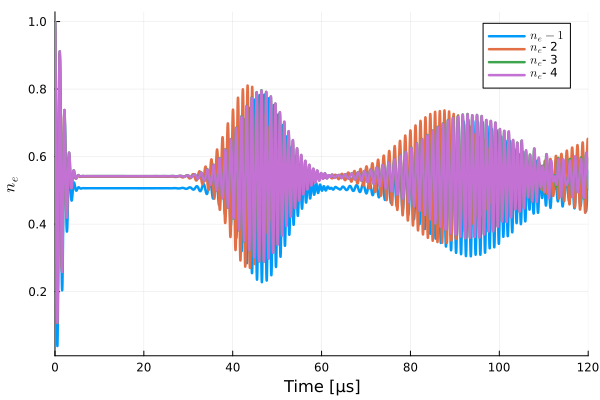

In [48]:
plot(tout[1], real(expect(2, σp_qo*σm_qo, ψt[1])), lw=2.5, label=L"n_e - 1"); 
for k in 2:order
    plot!(tout[k], real(expect(2, σp_qo*σm_qo, ψt[k])), lw=2.5, label=L"n_e"*"- $(k)")
end

xlims!(0, 120μs)
xlabel!("Time [μs]")
ylabel!(L"$n_e$")

### Solving using `QuantumCumulants.jl`

To solve, we start with defining a set of `QuantumCumulants.jl` variables into the Hamiltonian.

In [123]:
@cnumbers g_qc ωc_qc ωa_qc τ_qc
@syms t_qc::Real

subs = Dict(g => g_qc, ωc => ωc_qc, ωa => ωa_qc)

H_qc = []
for k in 1:order
    push!(H_qc, sum(qc_convert(g_eff[k], Ω_eff[k], subs, t_qc, τ_qc)))
end

In [124]:
ops = [a, a'*a, σ(:e, :e), σ(:g, :g)]

eqs = []
order = 2
for k in 1:order
    temp = meanfield(ops, H_qc[k], []; rates=[], order=2, iv=t_qc)
    complete!(temp)
    push!(eqs, temp)
end

In [125]:
#sys = [[] for k in 1:order]
sys = []
for k in 1:order
    @named temp = ODESystem(eqs[k])
    push!(sys, temp)
end

In [126]:
# units
μs = 1
MHz = 1/μs

# state definition: ψ = cg|g> + ce|e>
ce_iv = 1/sqrt(2)
cg_iv = 1/sqrt(2)
a_iv = sqrt(4.5)

# initial values:
σee_iv = abs(ce_iv)^2
σgg_iv = abs(cg_iv)^2
σeg_iv = conj(ce_iv)*cg_iv
σge_iv = conj(cg_iv)*ce_iv

ω0 = 200MHz
δ = 2MHz

u0 = ComplexF64[a_iv, abs(a_iv*a_iv), σee_iv, σgg_iv, a_iv*σee_iv, σeg_iv, a_iv*σge_iv, a_iv^2, a_iv*σeg_iv]
p0 = (ωa_qc=>2π*(ω0 - δ/2), ωc_qc=>2π*(ω0 + δ/2), g_qc=>2π*0.1MHz, τ_qc =>0.2μs)

t1 = 20μs
t_list = range(0, t1, length=500)
prob = []
for i in 1:order
    push!(prob, ODEProblem(sys[i], u0, (0.0, t1), p0))
end

sol = []
for i in 1:order 
    push!(sol, solve(prob[i], RK4(), saveat=t_list))
end 

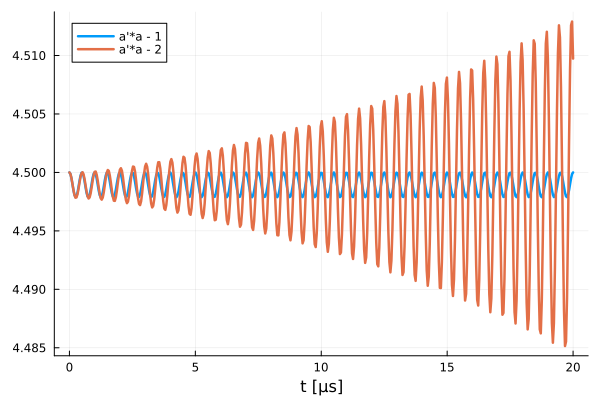

In [128]:
plot(t_list, abs.(sol[1][a'*a]), lw=2.5, label="a'*a - 1")
for i in 2:order
    plot!(t_list, abs.(sol[i][a'*a]), lw=2.5, label="a'*a - $i")
end
xlabel!("t [μs]")

The cumulant approach seems to be ill-fitted for this parameter regime.